In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import lon180, salmask, latweights, makedz

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'GISS2.1G'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
dsV = xr.open_dataset(folder+experiment+'/vo_100yr.nc',decode_times=False)
dsT = xr.open_dataset(folder+experiment+'/thetao_100yr.nc',decode_times=False)
dsS = xr.open_dataset(folder+experiment+'/so_100yr.nc',decode_times=False)
dsOHT = xr.open_dataset(folder+experiment+'/hfbasin_annual_100yr.nc',decode_times=False)
dsov = xr.open_dataset(folder+experiment+'/htovovrt_annual_100yr.nc',decode_times=False)
dsgyre = xr.open_dataset(folder+experiment+'/htovgyre_annual_100yr.nc',decode_times=False)

if experiment == 'E280':
    dsr = xr.open_dataset(folder+experiment+'/KB288X180.modelE.BS1.nc',decode_times=False)
else:
    dsr = xr.open_dataset(folder+experiment+'/KB288x180_PlioceneII_EstB.nc',decode_times=False)
    
#Copy Atlantic mask to same grid as S/T grid
dsr = dsr.assign_coords(lon=((360 + (dsr['lono'] % 360)) % 360)).sortby('lon')
ds = xr.Dataset(data_vars = dict(Atl=(("lat", "lon"), dsr.mask_atl.values)), coords = dict(lat = dsS.lat.values, lon = dsr.lon.values))
dsr = ds.copy(deep=True)

## Separation MOC and gyre FW Atlantic

In [5]:
vvel = dsV.vo*100 #vvel in cm/s
salt = dsS.so #salt in psu

region = dsr.Atl

In [6]:
ds = dsS.copy(deep=True)

#1-D spacing z-direction centered at midpoints where V and T are defined
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array spacing x-direction centered at T grid midpoints
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [7]:
#Define reference salinity S0 as average Atlantic salinity
folder2 = datafolder+'Processed/'
dssal = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssal = lon180(dssal)

S0 = dssal.so.where(salmask()>-1).weighted(makedz(dssal)).mean(dim='z').weighted(latweights()).mean()

In [8]:
SALT = salt.where(region>0)  

vvel = vvel.fillna(0).interp(lat = dsS.lat, lon = dsS.lon, method='linear')
vvel = vvel.where(region>0) #cm/s
VVEL = vvel*SALT/SALT

In [9]:
#zonal mean components 
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

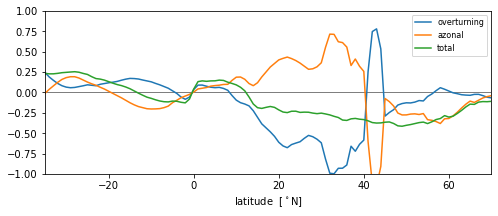

In [10]:
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(dsV.lat, Fov, label='overturning')
plt.plot(dsV.lat, Faz, label='azonal')
plt.plot(dsV.lat, Ftotal, label='total')
#plt.plot(dsV.lat, Fov+Faz, label='ov+az')

plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [12]:
dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov), Faz=(["lat"], Faz), Ftot=(["lat"], Ftotal)), coords = dict(lat = dsV.lat.values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador

In [14]:
#convert grids to -180-180 longitude to be able to select regions in Atlantic
dsS = lon180(dsS)
dsV = lon180(dsV)
dsr = lon180(dsr)

#Redo selecting velocity/salinity fields and making spacing arrays after conversion to -180-180 grid
vvel = dsV.vo*100 #vvel in cm/s
salt = dsS.so #salt in psu

region = dsr.Atl

ds = dsS.copy(deep=True)

#1-D spacing z-direction centered at midpoints where V and T are defined
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array spacing x-direction centered at T/S grid midpoints
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

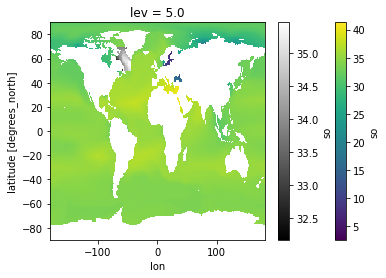

In [15]:
#show region
salt[0].plot()
salt[0].where(region>0).where(dsS.lon<-45).where(dsS.lon>-70).where(dsS.lat>=50).where(dsS.lat<70).plot(cmap='gray')

In [16]:
SALT = salt.where(region>0).where(dsS.lon<-45).where(dsS.lon>-70).where(dsS.lat>=50).where(dsS.lat<70)

vvel = vvel.fillna(0).interp(lat = dsS.lat, lon = dsS.lon, method='linear')
vvel = vvel.where(region>0).where(dsS.lon<-45).where(dsS.lon>-70).where(dsS.lat>=50).where(dsS.lat<70) #cm/s
VVEL = vvel*SALT/SALT

#zonal mean components
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[145:160]), Faz=(["lat"], Faz[145:160]), Ftot=(["lat"], Ftotal[145:160])), coords = dict(lat = dsV.lat[145:160].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

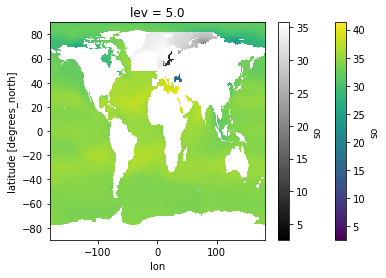

In [17]:
#show region
salt[0].plot()
salt[0].where(region>0).where(dsS.lon>=-45).where(dsS.lat>=50).plot(cmap='gray')

In [18]:
vvel = dsV.vo*100 #vvel in cm/s
salt = dsS.so #salt in psu

SALT = salt.where(region>0).where(dsS.lon>=-45).where(dsS.lat>=50)

vvel = vvel.fillna(0).interp(lat = dsS.lat, lon = dsS.lon, method='linear')
vvel = vvel.where(region>0).where(dsS.lon>=-45).where(dsS.lat>=50)
VVEL = vvel*SALT/SALT

#zonal mean components 
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#integrate for FW transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[145:170]), Faz=(["lat"], Faz[145:170]), Ftot=(["lat"], Ftotal[145:170])), coords = dict(lat = dsV.lat[145:170].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW Bering Strait

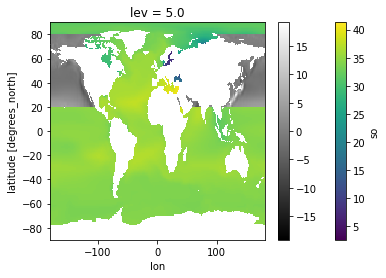

In [19]:
vvel = dsV.vo*100 #vvel in cm/s
vvel = vvel.fillna(0).interp(lat = dsS.lat, lon = dsS.lon, method='linear')

salt = dsS.so #salt in psu
vvel = vvel*salt/salt

#Show region
salt[0].plot()
vvel[0].where(region==0).where(dsS.lat>20).where(dsS.lat<80).plot(cmap='gray')

In [20]:
if experiment == 'E280':
    vvel = dsV.vo*100 #vvel in cm/s
    vvel = vvel.fillna(0).interp(lat = dsS.lat, lon = dsS.lon, method='linear')

    salt = dsS.so #salt in psu
    SALT = salt.where(region==0).where(dsS.lat>20).where(dsS.lat<80)
    
    VVEL = vvel*SALT/SALT

    #zonal mean components
    VVEL_zm = VVEL.mean(dim='lon')
    SALT_zm = SALT.mean(dim='lon')

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    #azonal components
    SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
    VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
    Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
    Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[110:170]), Faz=(["lat"], Faz[110:170]), Ftot=(["lat"], Ftotal[110:170])), coords = dict(lat = dsV.lat[110:170].values))    
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')